In [1]:
import os
import time
import cv2
import numpy as np
import torch
import torchvision
import torch.optim as optim

%matplotlib inline

import matplotlib.pyplot as plt

In [2]:
from model_vgg import Net

net = Net()
net.cuda()
print(net)

Net(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d(

In [3]:
import dataset

train_loader, val_loader = dataset.create_loaders(val_percent = 20, batch_size = 10)

print('training_size: %d, validation_size:%d' % (len(train_loader),len(val_loader)) )

training_size: 208, validation_size:52


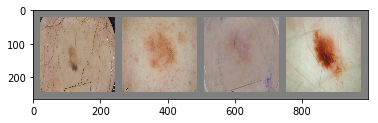

In [4]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images[0:4], nrow=4,padding=20))


In [5]:
def dice_coef(y_true, y_pred):
    intersection = torch.sum(y_true * y_pred)
    return (2. * intersection + 1.) / (torch.sum(y_true) + torch.sum(y_pred) + 1.)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def iou(y_true, y_pred):
    intersection = torch.sum(y_true * y_pred)
    return (intersection + 1.) / (torch.sum(y_true) + torch.sum(y_pred) - intersection + 1.)

def falsepos(y_true, y_pred):
    intersection = torch.sum(y_true * y_pred)
    return torch.sum(y_pred) - intersection

def falseneg(y_true, y_pred):
    intersection = torch.sum(y_true * y_pred)
    return torch.sum(y_true) - intersection

def precision(y_true, y_pred):
    intersection = torch.sum(y_true * y_pred)
    return intersection / (torch.sum(y_pred) + 1.)

def recall(y_true, y_pred):
    intersection = torch.sum(y_true * y_pred)
    return intersection / (torch.sum(y_true) + 1.)

def fscore(y_true, y_pred):
    presci = precision(y_true, y_pred)
    rec = recall(y_true, y_pred)
    return 2*(presci * rec)/(presci + rec)

def weighted_fscore_loss(prew=1, recw=1):
    def fscore_loss(y_true, y_pred):
        presci = precision(y_true, y_pred)
        rec = recall(y_true, y_pred)
        return -(prew+recw)*(presci * rec)/(prew*presci + recw*rec)
    return fscore_loss

In [6]:
from visualization import Visualization

learning_rate = 1e-5

optimizer = optim.Adam(net.parameters(), lr=learning_rate)
lrscheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer)

iou_vis = Visualization('IOU / Dice Coeff.')
fpfn_vis = Visualization('False Positive / False Negative')
fscore_vis = Visualization('Precision, Recall, F-Score')
loss_vis = Visualization('Mean loss')

measures = {
    'dice_coeff': (dice_coef, iou_vis), 
    'iou': (iou, iou_vis), 
    'fp': (falsepos, fpfn_vis), 
    'fn': (falseneg, fpfn_vis), 
    'precision': (precision, fscore_vis), 
    'recall': (recall, fscore_vis), 
    'fscore': (fscore, fscore_vis) }


In [7]:
import train

measurement_log = []
fscores = [(2,1)] * 5 + [(1.5,1)]*5 + [(1,1)]*5 + [(1,1.5)]*5 + [(1,2)]*5
frozen = [16]*25
# fscores = [(2,1)] * 5 + [(1.5,1)]*5 + [(1,1)]*5 + [(1,1.5)]*5 + [(1,2)]*5
# frozen = [9] * 25

for epoch in range(25):
    net.freeze(frozen[epoch])
    measurements = train.fit(net, train_loader, val_loader, weighted_fscore_loss(*(fscores[epoch])), optimizer, lrscheduler, measures, epoch, loss_vis)
    measurement_log.append(measurements)
    print("Epoch: %d: " % epoch, end='')
    for k,v in measurements.items():
        print(" {}:{:.5f}".format(k,v), end=',')
    print()

Epoch: 0:  dice_coeff:0.74881, iou:0.60484, fp:34835.57313, fn:9968.55983, precision:0.66527, recall:0.87276, fscore:0.74880, train_loss:-0.57421, val_loss:-0.78414,
Epoch: 1:  dice_coeff:0.80201, iou:0.67488, fp:27264.55672, fn:9320.34728, precision:0.73725, recall:0.88957, fscore:0.80200, train_loss:-0.82845, val_loss:-0.82803,
Epoch: 2:  dice_coeff:0.77106, iou:0.63393, fp:35895.69591, fn:3467.44809, precision:0.65605, recall:0.95071, fscore:0.77105, train_loss:-0.84921, val_loss:-0.82113,
Epoch: 3:  dice_coeff:0.82163, iou:0.70270, fp:26274.50308, fn:6450.04748, precision:0.74769, recall:0.92251, fscore:0.82162, train_loss:-0.86567, val_loss:-0.85148,
Epoch: 4:  dice_coeff:0.83648, iou:0.72399, fp:23040.97311, fn:7671.08128, precision:0.77887, recall:0.91240, fscore:0.83647, train_loss:-0.87597, val_loss:-0.85930,
Epoch: 5:  dice_coeff:0.84488, iou:0.73626, fp:21427.32121, fn:8032.55747, precision:0.79490, recall:0.91036, fscore:0.84487, train_loss:-0.87308, val_loss:-0.85650,
Epoc

In [8]:
import csv

timestamp = time.strftime('%m%d%H%M')
os.mkdir('./output_%s'%timestamp)

# write out weights
torch.save(net.state_dict(), './output_%s/ultrasound.pth' % timestamp)

# write out log
with open('./output_%s/info.txt' % timestamp, 'w') as f:
    f.write('%s\n' % time.strftime('%m-%d %H:%M'))
    f.write('optimizer: %s\n' % type(optimizer).__name__)
    f.write('scheduler: %s\n' % type(lrscheduler).__name__)
    f.write('learning_rate: %.6f\n' % learning_rate)
    f.write('\n')
    
with open('./output_%s/measurements.txt' % timestamp, 'w') as f:
    wr = csv.writer(f)
    wr.writerow(["Epoch"] + list(measurements.keys()))
    for epoch,measurement in enumerate(measurement_log):
        wr.writerow([epoch] + list(measurement.values()))

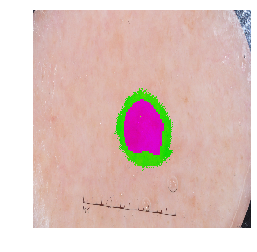

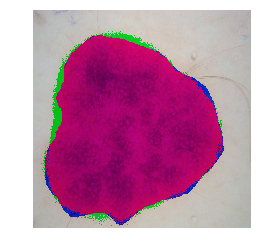

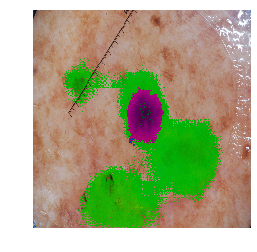

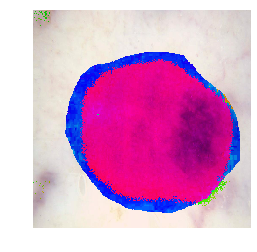

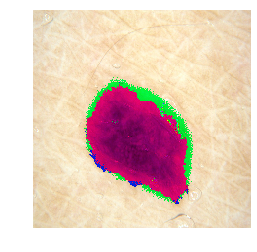

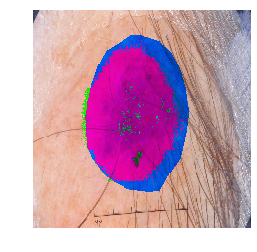

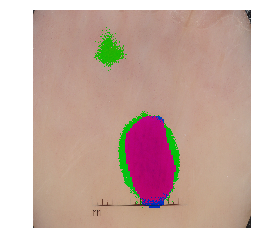

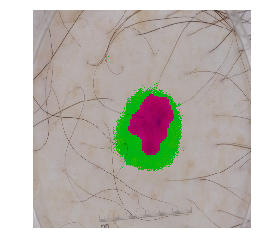

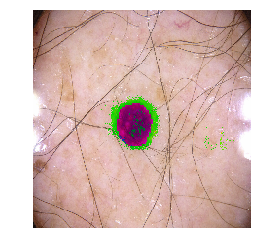

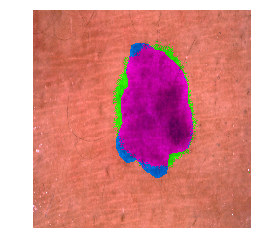

In [9]:
IMAGE_HT = 224
IMAGE_WD = 224

dataiter = iter(val_loader)
images, labels = dataiter.next()
images = images.cuda()
output = net(images)


for idx in range(10):
    x, y, label = images[idx], output[idx], labels[idx]
    
    y = y.reshape(IMAGE_HT, IMAGE_WD).cpu().detach().numpy()
    label = label.reshape(IMAGE_HT, IMAGE_WD).cpu().detach().numpy()

    # convert image to HSV for annotations
    img = x.cpu().detach().numpy()
    img = (img + 1) * 127
    img = img.astype(np.uint8)
    img = np.dstack((img[0,:,:], img[1,:,:], img[2,:,:]))
    img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

    # apply prediction and label markings
    h = img[:,:,0]
    s = img[:,:,1]
    h[y > .75] += 50 # GREEN
    s[y > .75] = 250
    h[label > .75] += 100 # BLUE
    s[label > .75] = 250

    img = cv2.cvtColor(img, cv2.COLOR_HSV2BGR)
    
    cv2.imwrite('./output_%s/%d.jpg'%(timestamp,idx), img)
    
    plt.figure()
    plt.axis('off')
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)